# Recurrent Neural Networks
Simple Pytorch LSTM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F

import time

import os
import joblib

import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Load the raw data stored in the specified ``csv`` file and inspect the overall data format. Our input is a sequence of closing prices of the stock, and the output is the closing price of the next day. This can be changed

In [2]:
# filepath = 'Bitcoin SV.csv'
filepath = 'bitcoin.csv'
data = pd.read_csv(os.path.join('../data', filepath))
# data = data.sort_values('Date')
data.head()


,Date,Open,High,Low,Close,Volume,Currency
0,2010-07-18,0.0,0.1,0.1,0.1,75,USD
1,2010-07-19,0.1,0.1,0.1,0.1,574,USD
2,2010-07-20,0.1,0.1,0.1,0.1,262,USD
3,2010-07-21,0.1,0.1,0.1,0.1,575,USD
4,2010-07-22,0.1,0.1,0.1,0.1,2160,USD


Plot the raw data.

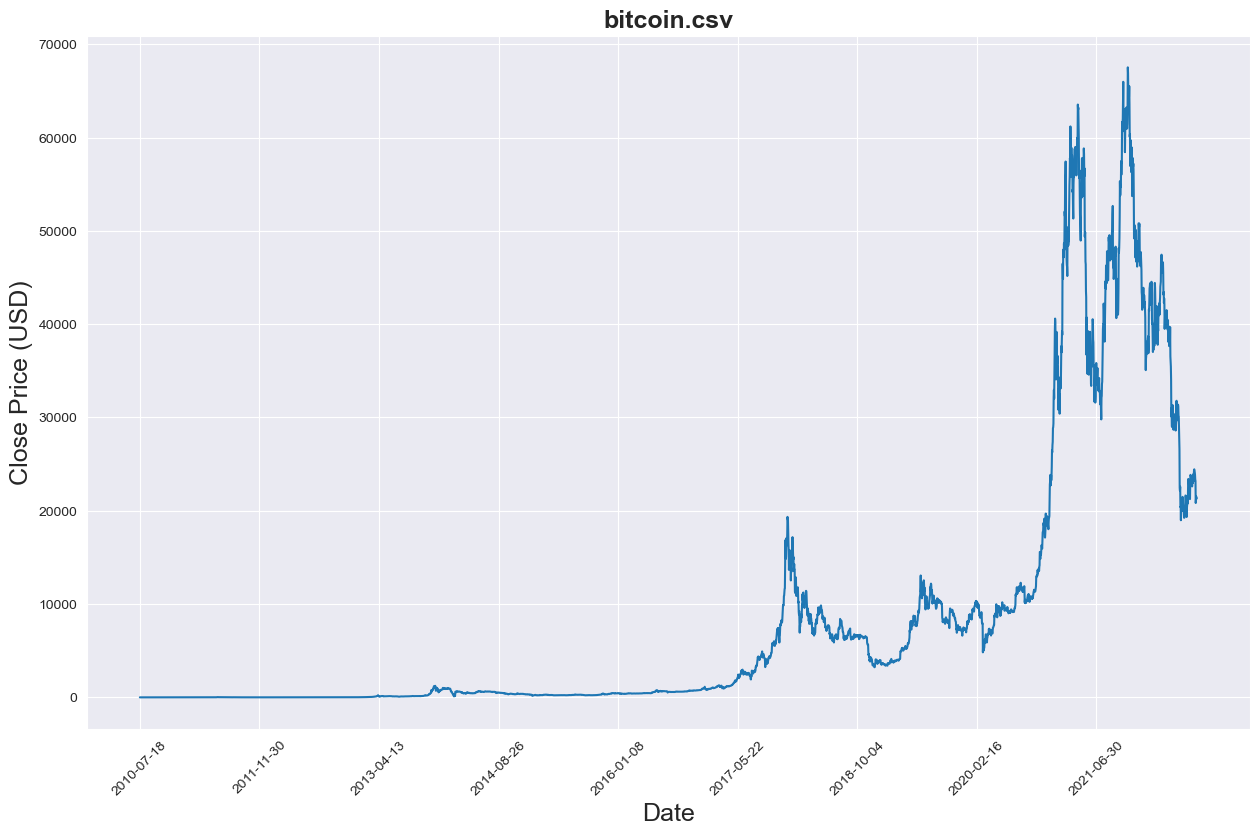

In [3]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title(filepath,fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()


Extract the ``Close`` column in the data frame as our data.

In [4]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4420 entries, 0 to 4419
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4420 non-null   float64
dtypes: float64(1)
memory usage: 34.7 KB


Normalize the raw data into the range of ``[-1, 1]``.

In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/var/folders/g5/dfwv37r13p54dmy66xm4mj3h0000gq/T/ipykernel_35390/2141647733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


The following method helps process the raw data into the desired input and output formats, and at the same time splits the train and test data.

In [6]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    x_train = torch.from_numpy(x_train)
    x_test = torch.from_numpy(x_test)
    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)
    x_train, y_train, x_test, y_test = x_train.float(), y_train.float(), x_test.float(), y_test.float()
    
    return [x_train, y_train, x_test, y_test]


Call the ``split_data`` function to retrieve ``x_train``, ``y_train``, ``x_test`` and ``y_test``.

In [7]:
# process the raw data
# lookback = 20 # choose sequence length
#### START CODE HERE (~1 line) ####
# x_train, y_train, x_test, y_test = split_data(price, lookback)
#### END CODE HERE ####
# print('x_train.shape = ',x_train.shape)
# print('y_train.shape = ',y_train.shape)
# print('x_test.shape = ',x_test.shape)
# print('y_test.shape = ',y_test.shape)


In [8]:
def get_train_test_data(data, lookback: int=20, verbose=True):
    x_train, y_train, x_test, y_test = split_data(data, lookback)
    if verbose:
        print('x_train.shape = ',x_train.shape)
        print('y_train.shape = ',y_train.shape)
        print('x_test.shape = ',x_test.shape)
        print('y_test.shape = ',y_test.shape)
    return x_train, y_train, x_test, y_test

In [9]:
def ablation_study(model, data, lookback, search_params):
    x_train, y_train, x_test, y_test = get_train_test_data(data, lookback, verbose=False)
    clf = GridSearchCV(model, search_params)
    clf.fit(x_train, y_train.ravel())
    return clf

Convert from ``numpy.array`` to ``torch.tensor``.

In [10]:
# Convert to torch Tensor
# x_train = torch.from_numpy(x_train)
# x_test = torch.from_numpy(x_test)
# y_train = torch.from_numpy(y_train)
# y_test = torch.from_numpy(y_test)
# x_train, y_train, x_test, y_test = x_train.float(), y_train.float(), x_test.float(), y_test.float()


Here provides the hyper-parameters for the assignment. You can try changing these hyper-parameters and observe the difference in the model's performance.

In [11]:
# hyper-parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 200
learning_rate = 0.001

## Built-in LSTM

1-layer LSTM network using the PyTorch built-in LSTM cell

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # for t in range(x.shape[1]):
        #     _, (ht, ct) = self.lstm(x[:,t], (ht, ct))
        output, (ht, ct) = self.lstm(x, (h0.detach(), c0.detach()))
        output = self.fc(output[:, -1, :]) 
        
        return output

In [13]:
model = NeuralNetRegressor(
    module=LSTM,
    criterion=nn.MSELoss,
    optimizer=torch.optim.Adam,
    verbose=True,
    module__input_dim=1,
    module__hidden_dim=64,
    module__output_dim=1
)

In [14]:
param_grid = {
    # 'module__input_dim': [1],
    # 'module__hidden_dim': [64],
    'module__num_layers': [1,2,3,4],
    # 'module__output_dim': [1],
    'max_epochs': [50, 100, 150, 200]
}
# grid = GridSearchCV(estimator=model, param_grid=param_grid)
# grid_result = grid.fit(x_train, y_train)

In [15]:
clfs = []
for lookback in [2, 5, 10, 15, 20, 25]:
    print('.', end='')
    clf = ablation_study(model, price, lookback, param_grid)
    clfs.append(clf)

.  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2607        0.0062  0.0431
      2        0.0071        0.0214  0.0282
      3        0.0177        0.0247  0.0264
      4        0.0236        0.0134  0.0260
      5        0.0177        0.0143  0.0257
      6        0.0169        0.0158  0.0246
      7        0.0174        0.0153  0.0245


/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([85])) that is different to the input size (torch.Size([85, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcastin

      8        0.0168        0.0147  0.0262
      9        0.0161        0.0144  0.0260
     10        0.0154        0.0140  0.0264
     11        0.0148        0.0137  0.0251
     12        0.0141        0.0133  0.0255
     13        0.0134        0.0129  0.0258
     14        0.0128        0.0125  0.0257
     15        0.0121        0.0121  0.0252
     16        0.0114        0.0118  0.0247
     17        0.0107        0.0114  0.0246
     18        0.0100        0.0111  0.0243
     19        0.0093        0.0107  0.0242
     20        0.0087        0.0104  0.0240
     21        0.0080        0.0101  0.0243
     22        0.0074        0.0097  0.0242
     23        0.0069        0.0093  0.0244
     24        0.0063        0.0089  0.0245
     25        0.0059        0.0085  0.0255
     26        0.0055        0.0082  0.0253
     27        0.0051        0.0078  0.0267
     28        0.0048        0.0076  0.0269
     29        0.0046        0.0074  0.0267
     30        0.0044        0.0

/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([85])) that is different to the input size (torch.Size([85, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcastin

      8        0.0168        0.0175  0.0271
      9        0.0161        0.0173  0.0333
     10        0.0154        0.0170  0.0370
     11        0.0147        0.0167  0.0259
     12        0.0140        0.0163  0.0257
     13        0.0133        0.0159  0.0259
     14        0.0125        0.0155  0.0262
     15        0.0118        0.0151  0.0258
     16        0.0110        0.0146  0.0262
     17        0.0103        0.0142  0.0254
     18        0.0096        0.0137  0.0256
     19        0.0089        0.0133  0.0252
     20        0.0083        0.0128  0.0243
     21        0.0077        0.0123  0.0249
     22        0.0071        0.0119  0.0242
     23        0.0067        0.0114  0.0251
     24        0.0062        0.0110  0.0250
     25        0.0059        0.0106  0.0344
     26        0.0056        0.0103  0.0633
     27        0.0054        0.0101  0.0309
     28        0.0052        0.0099  0.0256
     29        0.0051        0.0099  0.0256
     30        0.0050        0.0

/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([85])) that is different to the input size (torch.Size([85, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcastin

      8        0.0171        0.0179  0.0244
      9        0.0163        0.0175  0.0243
     10        0.0155        0.0171  0.0243
     11        0.0148        0.0166  0.0249
     12        0.0140        0.0162  0.0251
     13        0.0132        0.0157  0.0251
     14        0.0124        0.0152  0.0250
     15        0.0116        0.0146  0.0247
     16        0.0108        0.0141  0.0253
     17        0.0100        0.0136  0.0250
     18        0.0093        0.0131  0.0240
     19        0.0086        0.0126  0.0244
     20        0.0080        0.0121  0.0240
     21        0.0074        0.0116  0.0251
     22        0.0068        0.0111  0.0250
     23        0.0063        0.0106  0.0250
     24        0.0059        0.0101  0.0251
     25        0.0056        0.0097  0.0249
     26        0.0053        0.0094  0.0250
     27        0.0050        0.0091  0.0252
     28        0.0049        0.0090  0.0257
     29        0.0047        0.0089  0.0253
     30        0.0047        0.0

/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([85])) that is different to the input size (torch.Size([85, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcastin

      8        0.0134        0.0075  0.0246
      9        0.0133        0.0078  0.0249
     10        0.0130        0.0081  0.0242
     11        0.0127        0.0083  0.0244
     12        0.0123        0.0085  0.0240
     13        0.0119        0.0087  0.0242
     14        0.0115        0.0089  0.0241
     15        0.0110        0.0090  0.0240
     16        0.0106        0.0092  0.0240
     17        0.0101        0.0093  0.0245
     18        0.0097        0.0095  0.0244
     19        0.0093        0.0096  0.0246
     20        0.0089        0.0097  0.0241
     21        0.0085        0.0099  0.0241
     22        0.0081        0.0100  0.0247
     23        0.0078        0.0101  0.0243
     24        0.0074        0.0102  0.0245
     25        0.0072        0.0103  0.0246
     26        0.0069        0.0103  0.0246
     27        0.0067        0.0104  0.0249
     28        0.0065        0.0105  0.0246
     29        0.0063        0.0105  0.0246
     30        0.0061        0.0

/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([86])) that is different to the input size (torch.Size([86, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcastin

      4        0.0220        0.0305  0.0374
      5        0.0291        0.0263  0.0378
      6        0.0277        0.0262  0.0377
      7        0.0272        0.0269  0.0379
      8        0.0274        0.0263  0.0382
      9        0.0269        0.0255  0.0398
     10        0.0262        0.0249  0.0384
     11        0.0256        0.0243  0.0378
     12        0.0250        0.0237  0.0381
     13        0.0243        0.0232  0.0377
     14        0.0237        0.0228  0.0370
     15        0.0230        0.0225  0.0373
     16        0.0223        0.0222  0.0375
     17        0.0216        0.0220  0.0368
     18        0.0209        0.0218  0.0370
     19        0.0200        0.0216  0.0371
     20        0.0191        0.0215  0.0374
     21        0.0181        0.0214  0.0369
     22        0.0170        0.0212  0.0374
     23        0.0158        0.0209  0.0381
     24        0.0145        0.0204  0.0384
     25        0.0131        0.0196  0.0372
     26        0.0118        0.0

/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([85])) that is different to the input size (torch.Size([85, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcastin

      6        0.0304        0.0313  0.0398
      7        0.0294        0.0320  0.0382
      8        0.0294        0.0316  0.0377
      9        0.0290        0.0306  0.0367
     10        0.0283        0.0297  0.0370
     11        0.0275        0.0289  0.0382
     12        0.0267        0.0283  0.0385
     13        0.0260        0.0277  0.0393
     14        0.0252        0.0272  0.0385
     15        0.0245        0.0268  0.0385
     16        0.0237        0.0265  0.0385
     17        0.0229        0.0262  0.0378
     18        0.0220        0.0260  0.0371
     19        0.0211        0.0258  0.0381
     20        0.0201        0.0256  0.0380
     21        0.0190        0.0254  0.0390
     22        0.0179        0.0251  0.0424
     23        0.0166        0.0246  0.0390
     24        0.0153        0.0239  0.0367
     25        0.0140        0.0230  0.0369
     26        0.0127        0.0220  0.0376
     27        0.0116        0.0208  0.0386
     28        0.0106        0.0

/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([85])) that is different to the input size (torch.Size([85, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcastin

      6        0.0328        0.0368  0.0387
      7        0.0319        0.0368  0.0376
      8        0.0314        0.0364  0.0375
      9        0.0309        0.0353  0.0370
     10        0.0301        0.0341  0.0382
     11        0.0291        0.0330  0.0388
     12        0.0281        0.0321  0.0394
     13        0.0271        0.0313  0.0393
     14        0.0262        0.0306  0.0372
     15        0.0252        0.0300  0.0384
     16        0.0242        0.0295  0.0396
     17        0.0232        0.0291  0.0386
     18        0.0222        0.0287  0.0401
     19        0.0211        0.0283  0.0384
     20        0.0199        0.0279  0.0394
     21        0.0187        0.0274  0.0374
     22        0.0174        0.0268  0.0370
     23        0.0161        0.0260  0.0381
     24        0.0148        0.0251  0.0378
     25        0.0136        0.0239  0.0377
     26        0.0124        0.0227  0.0368
     27        0.0114        0.0215  0.0379
     28        0.0105        0.0

/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([85])) that is different to the input size (torch.Size([85, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcastin

      6        0.0275        0.0182  0.0390
      7        0.0287        0.0177  0.0385
      8        0.0285        0.0172  0.0377
      9        0.0280        0.0165  0.0375
     10        0.0273        0.0157  0.0379
     11        0.0265        0.0150  0.0373
     12        0.0257        0.0145  0.0373
     13        0.0249        0.0140  0.0366
     14        0.0242        0.0136  0.0375
     15        0.0235        0.0133  0.0375
     16        0.0228        0.0131  0.0370
     17        0.0222        0.0129  0.0366
     18        0.0216        0.0128  0.0372
     19        0.0210        0.0127  0.0364
     20        0.0204        0.0127  0.0373
     21        0.0197        0.0127  0.0369
     22        0.0191        0.0128  0.0367
     23        0.0185        0.0129  0.0363
     24        0.0178        0.0130  0.0365
     25        0.0172        0.0131  0.0367
     26        0.0165        0.0133  0.0370
     27        0.0158        0.0134  0.0373
     28        0.0151        0.0

/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([86])) that is different to the input size (torch.Size([86, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcastin

      6        0.0149        0.0021  0.0405
      7        0.0163        0.0021  0.0386
      8        0.0168        0.0018  0.0388
      9        0.0167        0.0015  0.0390
     10        0.0162        0.0014  0.0381
     11        0.0157        0.0013  0.0387
     12        0.0152        0.0012  0.0385
     13        0.0148        0.0012  0.0388
     14        0.0145        0.0012  0.0392
     15        0.0143        0.0011  0.0388
     16        0.0140        0.0011  0.0386
     17        0.0138        0.0011  0.0387
     18        0.0135        0.0011  0.0382
     19        0.0133        0.0011  0.0387
     20        0.0131        0.0011  0.0388
     21        0.0130        0.0011  0.0381
     22        0.0128        0.0011  0.0384
     23        0.0126        0.0011  0.0395
     24        0.0124        0.0011  0.0394
     25        0.0123        0.0011  0.0386
     26        0.0121        0.0012  0.0393
     27        0.0119        0.0012  0.0392
     28        0.0117        0.0

/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([85])) that is different to the input size (torch.Size([85, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/etchang/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcastin

      5        0.0315        0.0280  0.0502
      6        0.0305        0.0271  0.0677
      7        0.0297        0.0284  0.0511
      8        0.0304        0.0275  0.0507
      9        0.0300        0.0268  0.0504
     10        0.0294        0.0262  0.0504
     11        0.0289        0.0255  0.0505
     12        0.0284        0.0248  0.0508
     13        0.0279        0.0242  0.0495
     14        0.0275        0.0237  0.0493
     15        0.0270        0.0232  0.0490
     16        0.0266        0.0228  0.0488
     17        0.0263        0.0224  0.0492
     18        0.0259        0.0220  0.0493
     19        0.0256        0.0217  0.0494
     20        0.0253        0.0214  0.0496
     21        0.0250        0.0212  0.0496
     22        0.0248        0.0210  0.0509
     23        0.0245        0.0208  0.0499
     24        0.0242        0.0206  0.0504
     25        0.0240        0.0205  0.0500
     26        0.0237        0.0204  0.0490
     27        0.0235        0.0

In [ ]:
for i in range(len(clfs)):
    seq = [2, 5, 10, 15, 20, 25]
    joblib.dump(clfs[i], 'models/svr/gs_'+str(seq[i])+'seq.pkl')

In [ ]:
sequence_len = [2, 5, 10, 15, 20, 25]
rnn_grid_search = []
for i in range(len(sequence_len)):
    rnn_grid_search.append(joblib.load('models/svr/gs_'+str(sequence_len[i])+'seq.pkl'))

In [ ]:
params = ['max_epochs', 'module__num_layers']
search_params = ['_'.join(['param',param]) for param in params]

In [ ]:
for i in range(len(sequence_len)):
    print(rnn_grid_search[i].best_score_)

In [ ]:
best_acc = []
for i in range(len(sequence_len)):
    best_acc.append(rnn_grid_search[i].best_score_)

ax = plt.figure(figsize=(10,6))
plt.plot(best_acc)
plt.ylabel('R^2 Score')
plt.xlabel('Sequence Length')
plt.xticks(range(len(sequence_len)), [str(s) for s in sequence_len]);
plt.title('Best RNN Score vs. Sequence Length')
plt.savefig('figures/rnn/best_score_vs_len.png')

In [ ]:
for j in range(len(search_params)):
    param = search_params[j]
    fig = plt.figure(figsize=(10,6))
    index = pd.DataFrame(rnn_grid_search[0].cv_results_).groupby(param)['mean_test_score'].max().index
    for i in range(len(sequence_len)):
        temp = pd.DataFrame(rnn_grid_search[i].cv_results_)
        vals = temp.groupby(param)['mean_test_score'].max()
        plt.plot(vals.values, label='sequence: '+str(sequence_len[i]))
    plt.legend()
    plt.title('Best Support Vector Regression Score for parameter: '+params[j])
    plt.yscale('symlog')
    plt.xlabel(params[j])
    plt.ylabel('R^2 Score')
    plt.xticks(list(range(len(index))), index)
    plt.savefig('figures/rnn/best_score_vs_'+param+'.png')
    plt.show()

In [ ]:
# summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: -22482.606991 using {'max_epochs': 200, 'module__hidden_dim': 64, 'module__input_dim': 1, 'module__num_layers': 2, 'module__output_dim': 1}
-70114.182901 (139896.161689) with: {'max_epochs': 50, 'module__hidden_dim': 64, 'module__input_dim': 1, 'module__num_layers': 1, 'module__output_dim': 1}
-77948.760234 (154775.323517) with: {'max_epochs': 50, 'module__hidden_dim': 64, 'module__input_dim': 1, 'module__num_layers': 2, 'module__output_dim': 1}
-192085.537597 (383079.345554) with: {'max_epochs': 50, 'module__hidden_dim': 64, 'module__input_dim': 1, 'module__num_layers': 4, 'module__output_dim': 1}
-58693.386660 (117147.770792) with: {'max_epochs': 100, 'module__hidden_dim': 64, 'module__input_dim': 1, 'module__num_layers': 1, 'module__output_dim': 1}
-63133.026878 (126033.567181) with: {'max_epochs': 100, 'module__hidden_dim': 64, 'module__input_dim': 1, 'module__num_layers': 2, 'module__output_dim': 1}
-163705.725652 (326763.236507) with: {'max_epochs': 100, 'module__hidden_dim

In [ ]:
# lstm_model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

In [1]:
# hist = np.zeros(num_epochs)
# start_time = time.time()

# for t in range(num_epochs):
#     x_train = x_train.to(device)
#     y_train = y_train.to(device)
#     y_train_pred = lstm_model(x_train)

#     loss = criterion(y_train_pred, y_train)
#     print("Epoch ", t, "MSE: ", loss.item())
#     hist[t] = loss.item()

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
# training_time = time.time()-start_time
# print("Training time: {}".format(training_time))

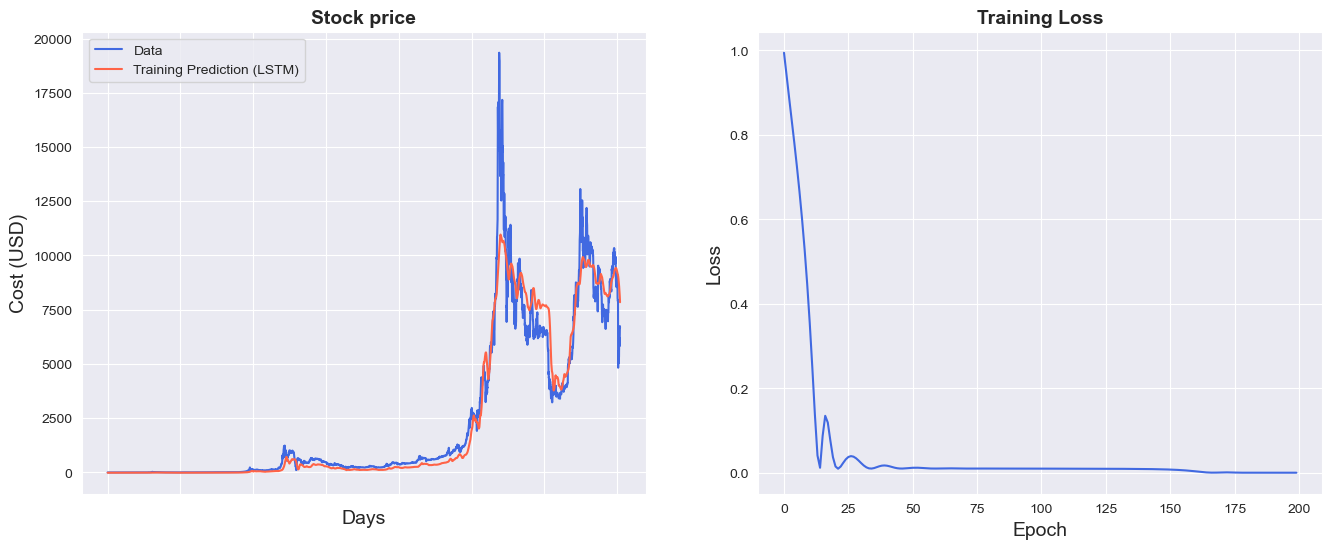

In [ ]:
# predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy()))
# original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

# sns.set_style("darkgrid")    

# fig = plt.figure()
# fig.subplots_adjust(hspace=0.2, wspace=0.2)

# plt.subplot(1, 2, 1)
# ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
# ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
# ax.set_title('Stock price', size = 14, fontweight='bold')
# ax.set_xlabel("Days", size = 14)
# ax.set_ylabel("Cost (USD)", size = 14)
# ax.set_xticklabels('', size=10)


# plt.subplot(1, 2, 2)
# ax = sns.lineplot(data=hist, color='royalblue')
# ax.set_xlabel("Epoch", size = 14)
# ax.set_ylabel("Loss", size = 14)
# ax.set_title("Training Loss", size = 14, fontweight='bold')
# fig.set_figheight(6)
# fig.set_figwidth(16)


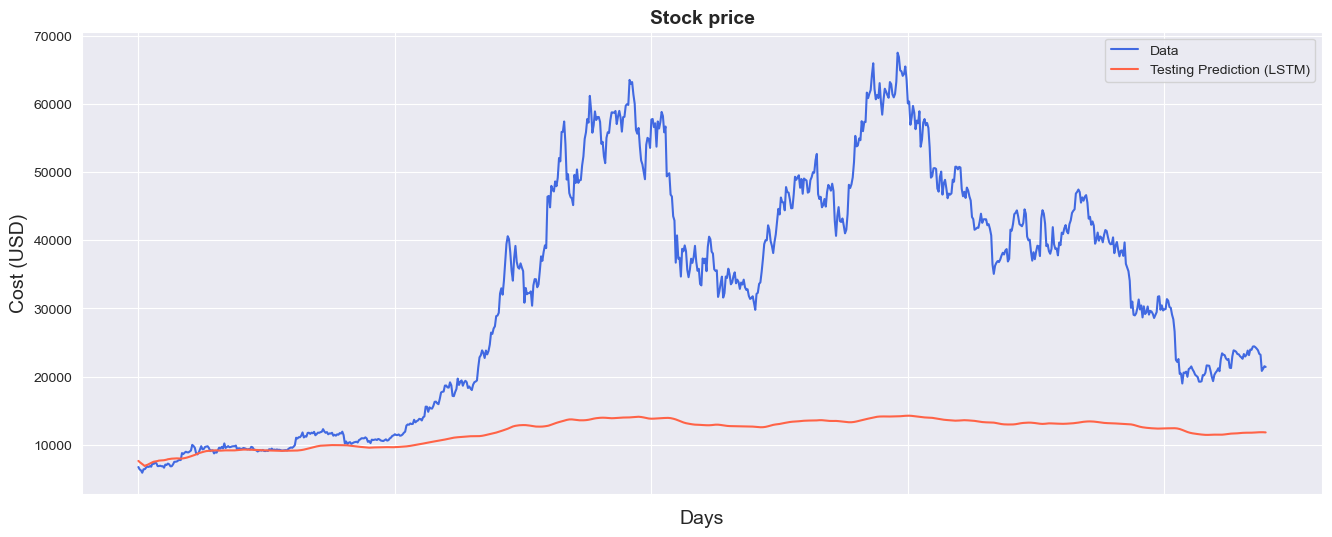

In [ ]:
# # make predictions
# with torch.no_grad():
#     x_test = x_test.to(device)
#     y_test_pred = lstm_model(x_test)

# predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()))
# original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

# sns.set_style("darkgrid")    

# fig = plt.figure()
# fig.subplots_adjust(hspace=0.2, wspace=0.2)

# plt.subplot(1, 1, 1)
# ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
# ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
# ax.set_title('Stock price', size = 14, fontweight='bold')
# ax.set_xlabel("Days", size = 14)
# ax.set_ylabel("Cost (USD)", size = 14)
# ax.set_xticklabels('', size=10)

# fig.set_figheight(6)
# fig.set_figwidth(16)

In [ ]:
# # calculate root mean squared error
# y_train2 = y_train.detach().cpu().numpy()
# y_train_pred = y_train_pred.detach().cpu().numpy()
# trainScore = np.sqrt(metrics.mean_squared_error(y_train2[:,0], y_train_pred[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))

# y_test2 = y_test.detach().cpu().numpy()
# y_test_pred = y_test_pred.detach().cpu().numpy()
# testScore = np.sqrt(metrics.mean_squared_error(y_test2[:,0], y_test_pred[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.76 RMSE


## Built-in GRU

1-layer GRU network using the PyTorch built-in GRU cell.

In [ ]:
# class GRU(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
#         super(GRU, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
        
#         self.gru_cell = nn.GRUCell(input_dim, hidden_dim, bias=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         ht = torch.zeros(x.size(0), self.hidden_dim).requires_grad_()

#         for t in range(x.shape[1]):
#             ht = self.gru_cell(x[:,t], ht)
#         out = self.fc(ht) 
#         return out

In [ ]:
# gru_model = GRU(input_dim, hidden_dim, 1, output_dim).to(device)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)

In [ ]:
# hist = np.zeros(num_epochs)
# start_time = time.time()

# for t in range(num_epochs):
#     x_train = x_train.to(device)
#     y_train = y_train.to(device)
#     y_train_pred = gru_model(x_train)

#     loss = criterion(y_train_pred, y_train)
#     print("Epoch ", t, "MSE: ", loss.item())
#     hist[t] = loss.item()

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
# training_time = time.time()-start_time
# print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.5042426586151123
Epoch  1 MSE:  0.46123045682907104
Epoch  2 MSE:  0.41922619938850403
Epoch  3 MSE:  0.3782261610031128
Epoch  4 MSE:  0.3382680118083954
Epoch  5 MSE:  0.2993924915790558
Epoch  6 MSE:  0.2616472542285919
Epoch  7 MSE:  0.2251121997833252
Epoch  8 MSE:  0.18991459906101227
Epoch  9 MSE:  0.15624970197677612
Epoch  10 MSE:  0.12440408021211624
Epoch  11 MSE:  0.09477941691875458
Epoch  12 MSE:  0.06792090833187103
Epoch  13 MSE:  0.04454862326383591
Epoch  14 MSE:  0.025579629465937614
Epoch  15 MSE:  0.012110904790461063
Epoch  16 MSE:  0.0052871499210596085
Epoch  17 MSE:  0.0058747208677232265
Epoch  18 MSE:  0.013253734447062016
Epoch  19 MSE:  0.024137629196047783
Epoch  20 MSE:  0.03345160558819771
Epoch  21 MSE:  0.037664953619241714
Epoch  22 MSE:  0.036320529878139496
Epoch  23 MSE:  0.031039506196975708
Epoch  24 MSE:  0.0240285936743021
Epoch  25 MSE:  0.01713400147855282
Epoch  26 MSE:  0.011498495005071163
Epoch  27 MSE:  0.007593044545501

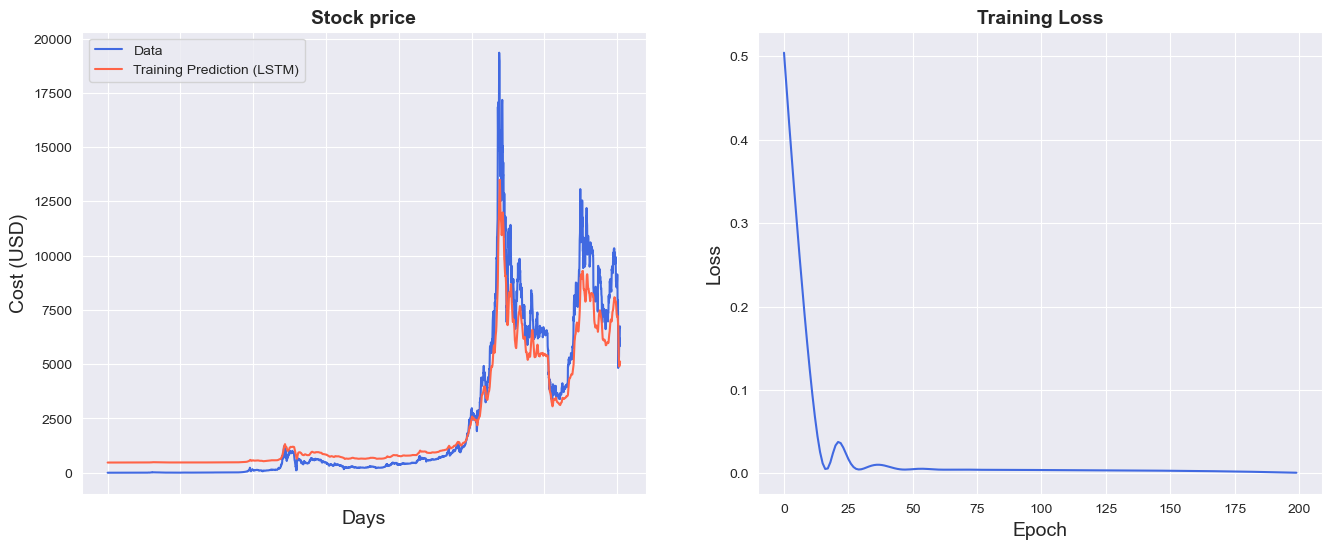

In [ ]:
# predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy()))
# original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

# sns.set_style("darkgrid")    

# fig = plt.figure()
# fig.subplots_adjust(hspace=0.2, wspace=0.2)

# plt.subplot(1, 2, 1)
# ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
# ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
# ax.set_title('Stock price', size = 14, fontweight='bold')
# ax.set_xlabel("Days", size = 14)
# ax.set_ylabel("Cost (USD)", size = 14)
# ax.set_xticklabels('', size=10)


# plt.subplot(1, 2, 2)
# ax = sns.lineplot(data=hist, color='royalblue')
# ax.set_xlabel("Epoch", size = 14)
# ax.set_ylabel("Loss", size = 14)
# ax.set_title("Training Loss", size = 14, fontweight='bold')
# fig.set_figheight(6)
# fig.set_figwidth(16)

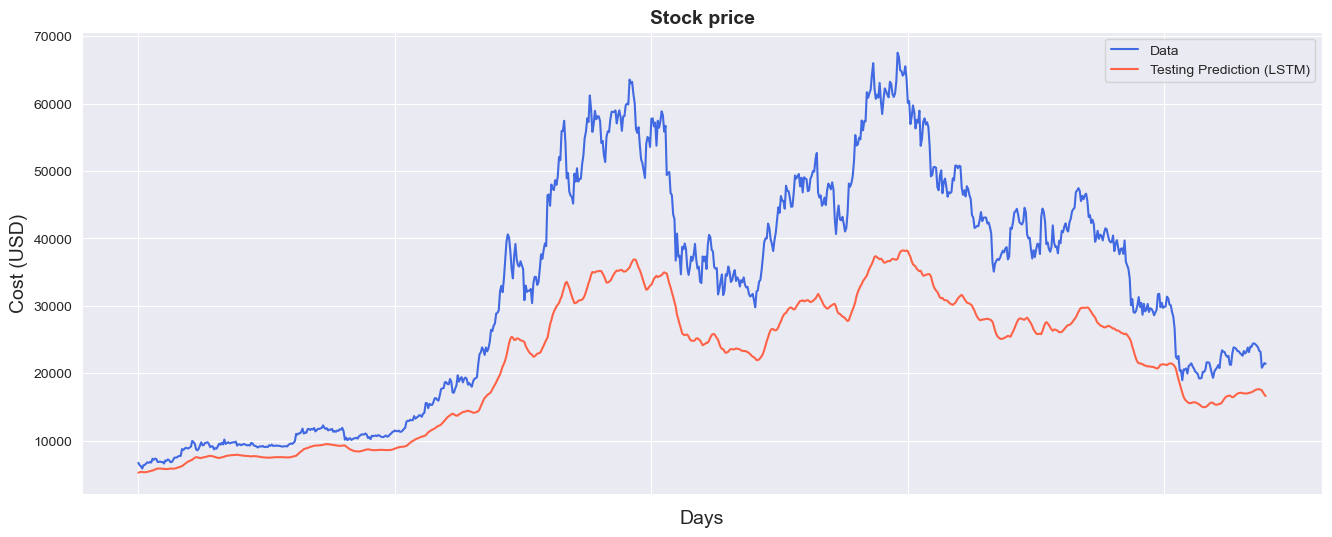

In [ ]:
# # make predictions
# with torch.no_grad():
#     x_test = x_test.to(device)
#     y_test_pred = gru_model(x_test)

# predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()))
# original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

# sns.set_style("darkgrid")    

# fig = plt.figure()
# fig.subplots_adjust(hspace=0.2, wspace=0.2)

# plt.subplot(1, 1, 1)
# ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
# ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
# ax.set_title('Stock price', size = 14, fontweight='bold')
# ax.set_xlabel("Days", size = 14)
# ax.set_ylabel("Cost (USD)", size = 14)
# ax.set_xticklabels('', size=10)

# fig.set_figheight(6)
# fig.set_figwidth(16)

In [ ]:
# # calculate root mean squared error
# y_train2 = y_train.detach().cpu().numpy()
# y_train_pred = y_train_pred.detach().cpu().numpy()
# trainScore = np.sqrt(metrics.mean_squared_error(y_train2[:,0], y_train_pred[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))

# y_test2 = y_test.detach().cpu().numpy()
# y_test_pred = y_test_pred.detach().cpu().numpy()
# testScore = np.sqrt(metrics.mean_squared_error(y_test2[:,0], y_test_pred[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.39 RMSE
